# Finding rotatable bonds in the Jnk1 ANI subset

In [3]:
from perses.utils.openeye import *
from openeye import oechem, oedepict, oegrapheme

In [ ]:
rotatable_bonds = {}

for ani_index in [0, 1, 2, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18]:
    mol = createOEMolFromSDF('Jnk1_ligands_shifted.sdf',index=ani_index)    
    oechem.OEAssignHybridization(mol)
    oedepict.OEPrepareDepiction(mol)
    mol.SetTitle(f'Jnk1-{ani_index}')

    opts = oedepict.OE2DMolDisplayOptions(500, 500, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)

    pen = oedepict.OEPen()
    glyph = oegrapheme.OEBondGlyphCurvedArrow(pen, 0.5)
    oegrapheme.OEAddGlyph(disp, glyph, oechem.OEIsRotor())

    oedepict.OERenderMolecule(f"Jnk1{ani_index}.png", disp)
    
    rotatables = []
    for bond in mol.GetBonds():
        if bond.IsRotor():
            rotatables.append((bond.GetBgn().GetName(), bond.GetEnd().GetName()))
            
    rotatable_bonds[ani_index] = rotatables

In [ ]:
print(rotatable_bonds)

In [12]:
import os
ligand_0_pdbs = [x for x in os.listdir('complex_500_steps/') if x[0:3] == 'old']
print(ligand_0_pdbs[0])


# mol = createOEMolFromSDF(f'complex_500_steps/{ligand_0_pdbs[0]}')
mol = createOEMolFromSDF('Jnk1_ligands_shifted.sdf')

INFO:utils.openeye:molecule 18629-1                      does not have unique atom names. Generating now...


old.0072.pdb


In [110]:
class IsRotatableOrMacroCycleBond(oechem.OEUnaryBondPred):
    """
    Identifies rotatable bonds and single bonds in macro-cycles.
    """
    def __call__(self, bond):
        """
        :type mol: oechem.OEBondBase
        :rtype: boolean
        """
        if bond.GetOrder() != 1:
            return False
        if bond.IsAromatic():
            return False

        isrotor = oechem.OEIsRotor()
        if isrotor(bond):
            return True

        if oechem.OEBondGetSmallestRingSize(bond) >= 10:
            return True

        return False

def get_dihedrals(mol):
    """
    Iterates over rotatable bonds and identifies their dihedral
    atoms. These atoms are added to the molecule in a group
    using the given tag.

    :type mol: oechem.OEMol
    :type itag: int
    :return: Number of dihedral angles identified
    :rtype: int
    """
    nrdihedrals = 0
    itag = 0
    for bond in mol.GetBonds(IsRotatableOrMacroCycleBond()):
        atomB = bond.GetBgn()
        atomE = bond.GetEnd()

        neighB = None
        neighE = None

        for atom in atomB.GetAtoms(oechem.OEIsHeavy()):
            if atom != atomE:
                neighB = atom
                break
        for atom in atomE.GetAtoms(oechem.OEIsHeavy()):
            if atom != atomB:
                neighE = atom
                break

        if neighB is None or neighE is None:
            continue

        atomorder = [neighB, atomB, atomE, neighE]
        bondorder = [mol.GetBond(neighB, atomB), bond, mol.GetBond(neighE, atomE)]

        if neighB.GetIdx() < neighE.GetIdx():
            atomorder.reverse()
            bondorder.reverse()

        atoms = oechem.OEAtomVector(atomorder)
        bonds = oechem.OEBondVector(bondorder)

        nrdihedrals += 1
        mol.NewGroup(itag, atoms, bonds)
        itag += 1

    return nrdihedrals, mol

def set_dihedral_histograms(mol, nrbins):
    """
    Iterates over the dihedral groups and bins the torsional
    angles for each conformation. The histogram data is then
    attached to the groups with the given tag.

    :type mol: oechem.OEMol
    :type itag: int
    :type nrbins: int
    """
    import math
    angleinc = 360.0 / float(nrbins)
    for group in mol.GetGroups():
        atoms = oechem.OEAtomVector()
        for atom in group.GetAtoms():
            atoms.append(atom)
        angles = []
        for conf in mol.GetConfs():
            rad = oechem.OEGetTorsion(conf, atoms[0], atoms[1], atoms[2], atoms[3])
            rad = (rad + np.pi) % (2 * np.pi) - np.pi
            angles.append(rad)
        group.SetData(group.GetGroupType(),angles)
    return mol

In [141]:
# need to make a mol with all of the MM samples together
mol = createOEMolFromSDF('Jnk1_ligands_shifted.sdf',index=5)

n_di, x_mol = get_dihedrals(mol)

new_mol = set_dihedral_histograms(x_mol,nrbins=10)

INFO:utils.openeye:molecule 18633-1                      does not have unique atom names. Generating now...


DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


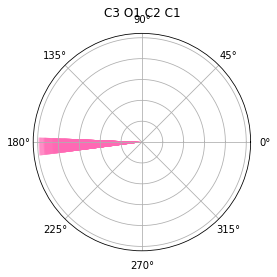

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


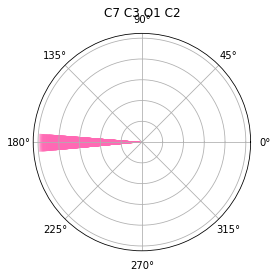

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


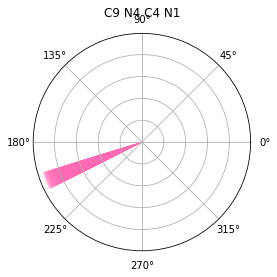

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


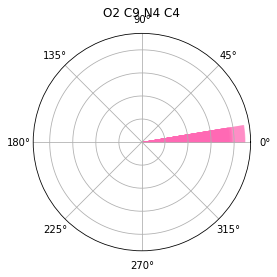

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


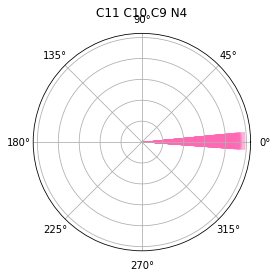

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


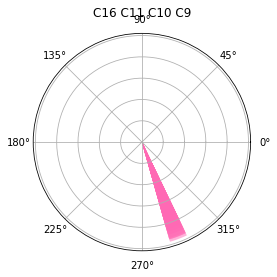

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


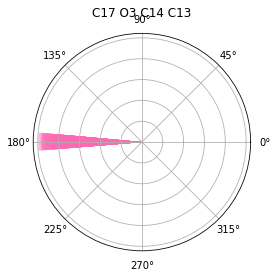

In [148]:
# Compute pie slices
N = 36 # in bins of 10 degree angles
bins = np.linspace(-np.pi, np.pi, N, endpoint=False)
width = bins[1] - bins[0]


for group in new_mol.GetGroups():
    ax = plt.subplot(111, projection='polar')
    radii = 10 * np.random.rand(N) # this needs to be the counts for each of the histogram bins
    ax.bar(group.GetData(group.GetGroupType()), radii, width=width, bottom=0.0, color='hotpink', alpha=0.5)

    ax.set_yticklabels('')
    plt.title(' '.join([x.GetName() for x in group.GetAtoms()]))
    plt.show()